# Example: Gate Concurrence Optimization

$
\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2}\mid{#2}\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}
$

In [1]:
using LinearAlgebra
using SparseArrays
using QuantumControl
using QuantumControl.Functionals: gate_functional, make_gate_chi
using QuantumControl.Amplitudes: ShapedAmplitude
using QuantumControl.Shapes: flattop
using TwoQubitWeylChamber: D_PE, gate_concurrence, unitarity

In [2]:
⊗ = kron;
const 𝕚 = 1im;

In [3]:
const N = 6;  # levels per transmon

In [4]:
function ket(i::Int64; N=N)
    Ψ = zeros(ComplexF64, N)
    Ψ[i+1] = 1
    return Ψ
end

function ket(indices::Int64...; N=N)
    Ψ = ket(indices[1]; N=N)
    for i in indices[2:end]
        Ψ = Ψ ⊗ ket(i; N=N)
    end
    return Ψ
end

function ket(label::AbstractString; N=N)
    indices = [parse(Int64, digit) for digit in label]
    return ket(indices...; N=N)
end;

In [5]:
using Plots
Plots.default(
    linewidth               = 3,
    size                    = (550, 300),
    legend                  = :right,
    foreground_color_legend = nothing,
    background_color_legend = RGBA(1, 1, 1, 0.8),
)
using QuantumControl.Controls: discretize

function plot_complex_pulse(tlist, Ω; time_unit=:ns, ampl_unit=:MHz, kwargs...)

    Ω = discretize(Ω, tlist)  # make sure Ω is defined on *points* of `tlist`

    ax1 = plot(
        tlist ./ eval(time_unit),
        abs.(Ω) ./ eval(ampl_unit);
        label="|Ω|",
        xlabel="time ($time_unit)",
        ylabel="amplitude ($ampl_unit)",
        kwargs...
    )

    ax2 = plot(
        tlist ./ eval(time_unit),
        angle.(Ω) ./ π;
        label="ϕ(Ω)",
        xlabel="time ($time_unit)",
        ylabel="phase (π)"
    )

    plot(ax1, ax2, layout=(2, 1))

end;

## Hamiltonian and guess pulses

We will write the Hamiltonian in units of GHz (angular frequency; the factor
2π is implicit) and ns:

In [6]:
const GHz = 2π
const MHz = 0.001GHz
const ns = 1.0
const μs = 1000ns;

The Hamiltonian and parameters are taken from
[Goerz *et al.*, Phys. Rev. A 91, 062307 (2015); Table 1](https://michaelgoerz.net/#GoerzPRA2015).

In [7]:
function guess_amplitudes(; T=400ns, E₀=35MHz, dt=0.1ns, t_rise=15ns)
    tlist = collect(range(0, T, step=dt))
    shape(t) = flattop(t, T=T, t_rise=t_rise)
    Ωre = ShapedAmplitude(t -> E₀, tlist; shape)
    Ωim = ShapedAmplitude(t -> 0.0, tlist; shape)
    return tlist, Ωre, Ωim
end

tlist, Ωre_guess, Ωim_guess = guess_amplitudes();

In [8]:
function transmon_hamiltonian(;
    Ωre, Ωim, N=N, ω₁=4.380GHz, ω₂=4.614GHz, ωd=4.498GHz, α₁=-210MHz,
    α₂=-215MHz, J=-3MHz, λ=1.03,
)
    𝟙 = SparseMatrixCSC{ComplexF64,Int64}(sparse(I, N, N))
    b̂₁ = spdiagm(1 => complex.(sqrt.(collect(1:N-1)))) ⊗ 𝟙
    b̂₂ = 𝟙 ⊗ spdiagm(1 => complex.(sqrt.(collect(1:N-1))))
    b̂₁⁺ = sparse(b̂₁'); b̂₂⁺ = sparse(b̂₂')
    n̂₁ = sparse(b̂₁' * b̂₁); n̂₂ = sparse(b̂₂' * b̂₂)
    n̂₁² = sparse(n̂₁ * n̂₁); n̂₂² = sparse(n̂₂ * n̂₂)
    b̂₁⁺_b̂₂ = sparse(b̂₁' * b̂₂); b̂₁_b̂₂⁺ = sparse(b̂₁ * b̂₂')

    ω̃₁ = ω₁ - ωd; ω̃₂ = ω₂ - ωd

    Ĥ₀ = sparse(
        (ω̃₁ - α₁ / 2) * n̂₁ +
        (α₁ / 2) * n̂₁² +
        (ω̃₂ - α₂ / 2) * n̂₂ +
        (α₂ / 2) * n̂₂² +
        J * (b̂₁⁺_b̂₂ + b̂₁_b̂₂⁺)
    )
    Ĥ₁re = sparse((1 / 2) * (b̂₁ + b̂₁⁺ + λ * b̂₂ + λ * b̂₂⁺))
    Ĥ₁im = sparse((𝕚 / 2) * (b̂₁⁺ - b̂₁ + λ * b̂₂⁺ - λ * b̂₂))
    return hamiltonian(Ĥ₀, (Ĥ₁re, Ωre), (Ĥ₁im, Ωim))
end;

In [9]:
H = transmon_hamiltonian(Ωre=Ωre_guess, Ωim=Ωim_guess);

## Maximization of Gate Concurrence

In [10]:
J_T_C = U -> 0.5 * (1 - gate_concurrence(U)) + 0.5 * (1 - unitarity(U));

In [11]:
basis = [ket("00"), ket("01"), ket("10"), ket("11")];

In [12]:
objectives = [Objective(; initial_state=Ψ, generator=H) for Ψ ∈ basis];

In [13]:
problem = ControlProblem(
    objectives=objectives,
    tlist=tlist,
    iter_stop=100,
    J_T=gate_functional(J_T_C),
    chi=make_gate_chi(J_T_C, objectives),
    check_convergence=res -> begin
        (
            (res.J_T <= 1e-3) &&
            (res.converged = true) &&
            (res.message = "Found a perfect entangler")
        )
    end,
    use_threads=true,
);

In [15]:
res = optimize(problem; method=:GRAPE)

 iter.        J_T     |∇J_T|       ΔJ_T   FG(F)    secs
     0   1.57e-01   1.42e-01        n/a    1(0)     0.5
     1   1.46e-01   3.18e-01  -1.05e-02    1(0)     0.3
     2   1.30e-01   2.86e-01  -1.61e-02    1(0)     0.2
     3   8.10e-02   2.10e-01  -4.91e-02    2(0)     0.4
     4   7.66e-02   3.79e-01  -4.41e-03    1(0)     0.2
     5   4.89e-02   1.87e-01  -2.77e-02    1(0)     0.2
     6   2.64e-02   2.11e-01  -2.25e-02    1(0)     0.2
     7   7.54e-03   1.09e-01  -1.89e-02    1(0)     0.2
     8   5.86e-03   1.98e-01  -1.68e-03    1(0)     0.2
     9   3.00e-03   4.01e-02  -2.87e-03    1(0)     0.2
    10   2.71e-03   2.72e-02  -2.88e-04    1(0)     0.3
    11   2.21e-03   2.82e-02  -5.01e-04    1(0)     0.2
    12   1.42e-03   2.46e-02  -7.84e-04    1(0)     0.2
    13   3.24e-04   2.83e-02  -1.10e-03    1(0)     0.2


GRAPE Optimization Result
-------------------------
- Started at 2023-03-22T17:24:04.607
- Number of objectives: 4
- Number of iterations: 13
- Number of pure func evals: 0
- Number of func/grad evals: 15
- Value of functional: 3.24322e-04
- Reason for termination: Found a perfect entangler
- Ended at 2023-03-22T17:24:08.507 (3 seconds, 900 milliseconds)


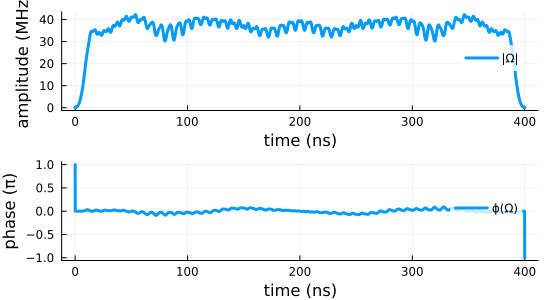

In [16]:
ϵ_opt = res.optimized_controls[1] + 𝕚 * res.optimized_controls[2]
Ω_opt = ϵ_opt .* discretize(Ωre_guess.shape, tlist)

plot_complex_pulse(tlist, Ω_opt)